# Argentine Basin Supplement
## Plotting Satellite SST Data
OOI Data Labs Education Nuggets

_Written by Lori Garzio, Rutgers University_

_Disclaimer: data used in this example were accessed on Aug 19, 2020._

**Objective**: Demonstrate how to access satellite Sea Surface Temperature data from the Physical Oceanography Distributed Active Archive Center ([PO.DAAC](https://podaac.jpl.nasa.gov/)) and make plots.

For this example, we will be using a Group for High Resolution Sea Surface Temperature (GHRSST) Level 4 sea surface temperature analysis produced at the Naval Oceanographic Office (NAVOCEANO).

In [1]:
# Notebook Setup
import datetime as dt
import xarray as xr
import numpy as np
import pandas as pd
import requests
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Data Access

The Jet Propulsion Laboratory at the California Institute of Technology provides a data center ([PO.DAAC](https://podaac.jpl.nasa.gov/)) that distributes different types of physical oceanographic data products, including sea surface temperature. This tutorial will demonstrate how to access and use a [Group for High Resolution Sea Surface Temperature (GHRSST) Level 4 sea surface temperature analysis](https://podaac.jpl.nasa.gov/dataset/NAVO-L4HR1m-GLOB-K10_SST) produced at the Naval Oceanographic Office (NAVOCEANO).

Once you review the information about the dataset, you can access the PO.DAAC THREDDS server for this dataset in the Data Access tab. In the THREDDS server, click on the OPENDAP link, and copy the Data URL below to access the data via Python. You will also need to specify:

* the path to a local directory to which you want to save the plots
* the minimum and maximum latitude and longitudes you want to plot
* the date range you want to plot

In [2]:
# data url
sat_file = 'https://thredds.jpl.nasa.gov/thredds/dodsC/ncml_aggregation/OceanTemperature/ghrsst/aggregate__ghrsst_NAVO-L4HR1m-GLOB-K10_SST.ncml'
# GHRSST Level 4 K10_SST Global 1 meter Sea Surface Temperature Analysis

# save file directory - change this to a local directory
save_dir = '/Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite'

# define the coordinate limits to subset and plot
model_lims = dict(minlon=-75, maxlon=-15, minlat=-60, maxlat=-15)

# date to plot
start_date = dt.datetime(2016, 5, 25, 0, 0, 0)
end_date = dt.datetime(2016, 6, 25, 0, 0, 0)

Open the data file and subset the dataset for the date range you want to plot.

In [3]:
# open the dataset
ds = xr.open_dataset(sat_file, mask_and_scale=False)

# subset based on time
ds = ds.sel(time=slice(start_date, end_date + dt.timedelta(days=1)))

# print the dataset to see the dimensions, coordinates, variables, etc
ds

<xarray.Dataset>
Dimensions:         (lat: 1801, lon: 3600, time: 33)
Coordinates:
  * lat             (lat) float32 90.0 89.9 89.8 89.700005 ... -89.8 -89.9 -90.0
  * lon             (lon) float32 -180.0 -179.90001 -179.8 ... 179.8 179.90001
  * time            (time) object 2016-05-25 00:00:00 ... 2016-06-26 00:00:00
Data variables:
    analysed_sst    (time, lat, lon) int16 ...
    analysis_error  (time, lat, lon) int16 ...
    mask            (time, lat, lon) int8 ...
Attributes:
    Conventions:            NAVO_netcdf_v3.4
    title:                  NAVOCEANO 10km Analyzed Sea Surface Temperature
    DSD_entry_id:           NAVO-L4HR1m-GLOB-K10_SST
    reference:              https://oceanography.navy.mil/legacy/web
    institution:            Naval Oceanographic Office
    contact:                doug.may@navy.mil
    GDS_version_id:         v1.0-rev1.7
    netcdf_version_id:      netcdf v3.4
    history:                Created from k10.out, k10a.out
    operational_status:     

In [4]:
# grab the time, latitude, and longitude variables
tm = ds['time']
lon = ds['lon']
lat = ds['lat']

In [5]:
# print the time variable
tm

<xarray.DataArray 'time' (time: 33)>
array([cftime.DatetimeGregorian(2016, 5, 25, 0, 0, 0, 0),
       cftime.DatetimeGregorian(2016, 5, 26, 0, 0, 0, 0),
       cftime.DatetimeGregorian(2016, 5, 27, 0, 0, 0, 0),
       cftime.DatetimeGregorian(2016, 5, 28, 0, 0, 0, 0),
       cftime.DatetimeGregorian(2016, 5, 29, 0, 0, 0, 0),
       cftime.DatetimeGregorian(2016, 5, 30, 0, 0, 0, 0),
       cftime.DatetimeGregorian(2016, 5, 31, 0, 0, 0, 0),
       cftime.DatetimeGregorian(2016, 6, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(2016, 6, 2, 0, 0, 0, 0),
       cftime.DatetimeGregorian(2016, 6, 3, 0, 0, 0, 0),
       cftime.DatetimeGregorian(2016, 6, 4, 0, 0, 0, 0),
       cftime.DatetimeGregorian(2016, 6, 5, 0, 0, 0, 0),
       cftime.DatetimeGregorian(2016, 6, 6, 0, 0, 0, 0),
       cftime.DatetimeGregorian(2016, 6, 7, 0, 0, 0, 0),
       cftime.DatetimeGregorian(2016, 6, 8, 0, 0, 0, 0),
       cftime.DatetimeGregorian(2016, 6, 9, 0, 0, 0, 0),
       cftime.DatetimeGregorian(2016, 6, 10,

This dataset has one timestamp per day and covers the entire globe. We want to subset the data to zoom in to the Argentine Basin Array region. In order to do that, we'll create indices where latitude and longitude are within our coordinates defined above, and select the SST data just within those coordinates. The SST variable is called 'analysed_sst'.

In [6]:
lon_ind = np.logical_and(lon > model_lims['minlon'], lon < model_lims['maxlon'])
lat_ind = np.logical_and(lat > model_lims['minlat'], lat < model_lims['maxlat'])

# grab the SST data within the defined coordinates
sst = np.squeeze(ds['analysed_sst'][:, lat_ind, lon_ind])
sst

<xarray.DataArray 'analysed_sst' (time: 33, lat: 449, lon: 599)>
[8875383 values with dtype=int16]
Coordinates:
  * lat      (lat) float32 -15.1 -15.2 -15.3 -15.400001 ... -59.7 -59.8 -59.9
  * lon      (lon) float32 -74.9 -74.8 -74.700005 -74.6 ... -15.3 -15.2 -15.1
  * time     (time) object 2016-05-25 00:00:00 ... 2016-06-26 00:00:00
Attributes:
    long_name:      Analyzed Sea Surface Temperature
    standard_name:  sea_surface_temperature
    type:           depth 1m
    units:          kelvin
    _FillValue:     -32768
    add_offset:     273.15
    scale_factor:   0.1
    valid_min:      -20
    valid_max:      350

Take a look at the attributes for SST - the units are in degrees Kelvin, add_offset = 273.15, and there is a scale_factor. In order to get degrees Celsius for this dataset, we need to multiply the data by the scale factor and not apply the 'add_offset' attribute (which makes the values degrees Kelvin instead of Celsius). We will do this later in the notebook.

## Set up plot for one timestamp

Here is a function to plot the SST data, add map features to the plot, add the locations of the Argentine Basin moorings, and save the plot to a directory on your local machine (if the file path is provided).

In [7]:
def plot_sst(plt_ttl, clabel, lon_data, lat_data, data, array_loc, cmin, cmax, save_figname=None):
    """
    Create a pcolor surface map of SST
    plt_ttl: title for the plot
    clabel: label for the color bar
    lon_data: longitude data
    lat_data: latitude data
    data: variable data
    array_loc: data frame containing mooring coordinates
    cmin: minimum value for color bar
    cmax: maximum value for color bar
    save_figname: optional, full file path to save directory and save filename
    """
    # set up the map
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

    plt.subplots_adjust(right=0.88)  # adjust the right margin of the plot
    plt.title(plt_ttl, fontsize=15)  # add the title

    # format the spacing of the colorbar
    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size='5%', pad=0.1, axes_class=plt.Axes)
    fig.add_axes(cax)

    # plot the data
    h = ax.pcolor(lon_data, lat_data, data, vmin=cmin, vmax=cmax, cmap='jet')
    #h = ax.pcolor(lon_data, lat_data, data, vmin=2, vmax=20, cmap='jet')

    # add the color bar
    cb = plt.colorbar(h, cax=cax)
    cb.set_label(label=clabel, fontsize=14)  # add the label on the colorbar
    cb.ax.tick_params(labelsize=12)  # format the size of the tick labels

    # add the latitude and longitude gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=.5, color='gray', 
                      alpha=0.5, linestyle='dotted')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 13}
    gl.ylabel_style = {'size': 13}

    # add map features
    land = cfeature.NaturalEarthFeature('physical', 'land', '10m')
    ax.add_feature(land, edgecolor='black', facecolor='lightgray')

    state_lines = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

    ax.add_feature(cfeature.BORDERS, zorder=6)
    ax.add_feature(state_lines, zorder=7, edgecolor='black')
    
    # add the mooring locations
    ax.scatter(array_loc.lon, array_loc.lat, s=75, marker='d', color='w', edgecolor='black')

    # save the figure only if a figure path is provided
    if save_figname is not None:
        plt.savefig(save_figname, dpi=200)
    
    plt.show()
    plt.close()

Now, we will get the data for SST just at the first timestamp in our dataset, calculate SST in degrees Celsius by multiplying by the scale_factor, get the locations of the Argentine Basin moorings, and pass all of the information to the plotting function.

In [8]:
# get the data for SST at the first timestamp in the time array
t = tm[0]  # grab the first timestamp
sst_t0 = sst.sel(time=t.values)

# convert integers to floats, then convert fill values to NaNs
sst_t0 = sst_t0.astype('float')
sst_t0.values[sst_t0 == -32768] = np.nan

# convert using scale_factor and don't add 273.15 (keep degrees Celsius)
sst_t0 = sst_t0 * sst.scale_factor

print(sst_t0)

<xarray.DataArray 'analysed_sst' (lat: 449, lon: 599)>
array([[ nan,  nan,  nan, ..., 25.1, 25.2, 25.1],
       [ nan,  nan,  nan, ..., 25.1, 25.2, 25.1],
       [ nan,  nan,  nan, ..., 25.1, 25.2, 25.1],
       ...,
       [ 4.1,  4.2,  4.2, ..., -1.1, -1.1, -1.1],
       [ 4.1,  4.1,  4.1, ..., -1.1, -1.1, -1.1],
       [ 3.9,  4. ,  3.9, ..., -1.1, -1.1, -1.1]])
Coordinates:
  * lat      (lat) float32 -15.1 -15.2 -15.3 -15.400001 ... -59.7 -59.8 -59.9
  * lon      (lon) float32 -74.9 -74.8 -74.700005 -74.6 ... -15.3 -15.2 -15.1
    time     object 2016-05-25 00:00:00


Here is a function to return all of the locations of the moorings from an OOI array, using the [Rutgers OOI Data Review Database](https://datareview.marine.rutgers.edu/).

In [9]:
def return_array_subsites_standard_loc(array):
    DBurl= 'https://datareview.marine.rutgers.edu/regions/view/{}.json'.format(array)
    r = requests.get(DBurl)
    url_ct = r.json()['region']['sites']
    loc_df = pd.DataFrame()
    for ii in range(len(url_ct)):
        if url_ct[ii]['reference_designator'] != 'GA05MOAS':
            data = {
                    'lat': url_ct[ii]['latitude'],
                    'lon': url_ct[ii]['longitude'],
                    'max_z': url_ct[ii]['max_depth']
                    }
            new_r = pd.DataFrame(data, columns=['lat', 'lon', 'max_z'], 
                                 index=[url_ct[ii]['reference_designator']])
            loc_df = loc_df.append(new_r)
    return loc_df

In [10]:
array_location = return_array_subsites_standard_loc('GA')
print(array_location)

              lat      lon  max_z
GA01SUMO -42.9204 -42.4409   5200
GA02HYPM -42.9781 -42.4957   5200
GA03FLMA -42.4921 -42.8802   5200
GA03FLMB -42.4960 -42.1255   5200


Define information for the plot such as the label names.

In [11]:
# define labels for plot
# convert timestamp to string
timestr = '{}-{}-{}'.format(t.values.tolist().month, t.values.tolist().day, t.values.tolist().year)
print('Currently plotting: {}'.format(timestr))

# define plot title and color label title
title = '{}'.format(timestr)
color_label = 'SST ($^\circ$C)'

Currently plotting: 5-25-2016


## Generate plot

Finally, let's pass the information to the function to create a plot (which may take several minutes to create). This time, we won't pass the save file path (the last argument) to the function, so the plot will be displayed below but not saved to your local machine. After we confirm the plotting function works, we can write a loop to make more than one plot and save those plots to your local machine.

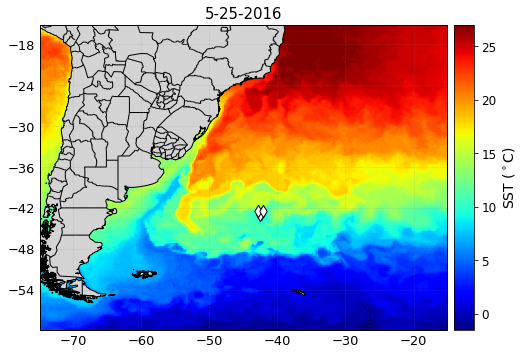

In [12]:
# pass the necessary information to the function to create the plot (without the save file path)
plot_sst(title, color_label, sst_t0.lon.values, sst_t0.lat.values, sst_t0.values, array_location, -1.5, 27)

Here is a zoomed-out image of Sea Surface Temperature on May 25, 2016 in the South Atlantic region, with the locations of the Argentine Basin moorings indicated by the cluster of white diamonds. Now that we can see where the mooring is located in relation to South America, let's zoom in more on the array to be able to see more details.

In [13]:
# zoom in further by resetting the coordinate limits
model_lims = dict(minlon=-50, maxlon=-35, minlat=-50, maxlat=-36)

# subset the SST data again using the new coordinate limits
lon_ind = np.logical_and(lon > model_lims['minlon'], lon < model_lims['maxlon'])
lat_ind = np.logical_and(lat > model_lims['minlat'], lat < model_lims['maxlat'])

# grab the SST data within the defined coordinates
sst = np.squeeze(ds['analysed_sst'][:, lat_ind, lon_ind])

# get the data for SST at the first timestamp in the time array
t = tm[0]  # grab the first timestamp
sst_t0 = sst.sel(time=t.values)

# convert integers to floats, then convert fill values to NaNs
sst_t0 = sst_t0.astype('float')
sst_t0.values[sst_t0 == -32768] = np.nan

# convert using scale_factor and don't add 273.15 (keep degrees Celsius)
sst_t0 = sst_t0 * sst.scale_factor

print(sst_t0)

<xarray.DataArray 'analysed_sst' (lat: 139, lon: 149)>
array([[20.3, 20.3, 20.2, ..., 18.2, 18.1, 18.1],
       [20.2, 20.2, 20.2, ..., 18.2, 18.1, 18. ],
       [20.2, 20.2, 20.3, ..., 18.1, 18.1, 18. ],
       ...,
       [ 3.8,  3.8,  3.7, ...,  2.9,  2.9,  3. ],
       [ 3.7,  3.6,  3.6, ...,  2.8,  2.9,  2.9],
       [ 3.7,  3.6,  3.6, ...,  2.7,  2.8,  2.9]])
Coordinates:
  * lat      (lat) float32 -36.100002 -36.2 -36.3 -36.4 ... -49.7 -49.8 -49.9
  * lon      (lon) float32 -49.9 -49.8 -49.7 ... -35.3 -35.2 -35.100002
    time     object 2016-05-25 00:00:00


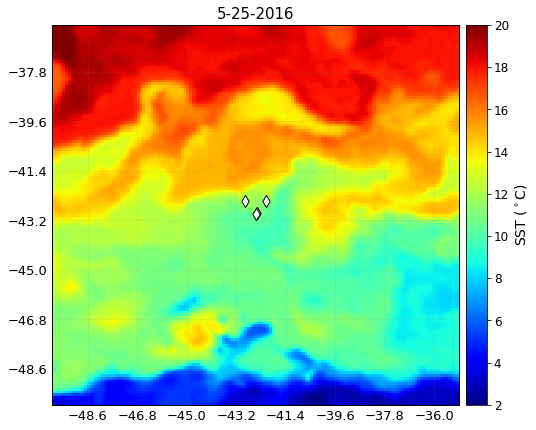

In [14]:
# plot the data again within the smaller region, and change the color bar limits
plot_sst(title, color_label, sst_t0.lon.values, sst_t0.lat.values, sst_t0.values, array_location, 2, 20)

Here we have zoomed in to the Argentine Basin array where you can see the locations of the moorings more clearly, and can see more details of the SST. Now that we have verified that the plotting function works, let's generate plots for the entire time range to see what happens with the SST during this time range. We will also save the images to your local machine - this will take several minutes to complete.

Currently plotting: 5-25-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160525.png


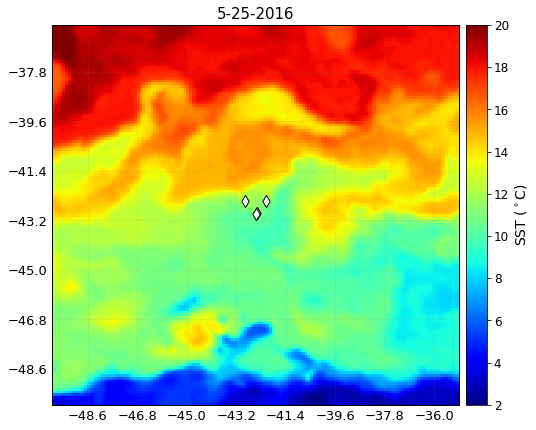

Currently plotting: 5-26-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160526.png


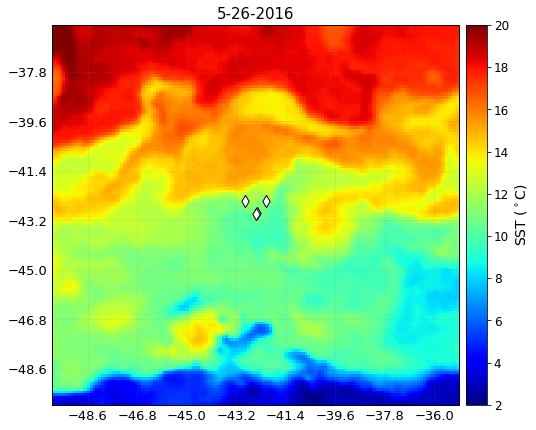

Currently plotting: 5-27-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160527.png


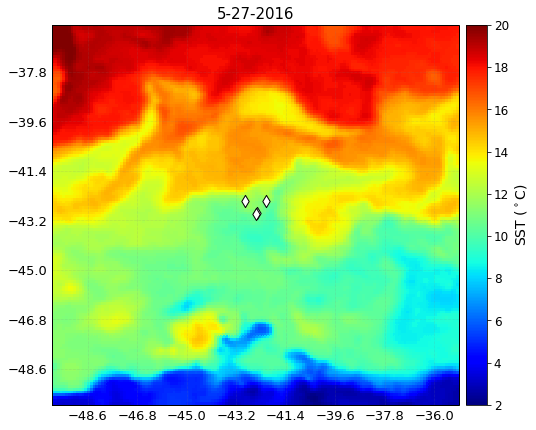

Currently plotting: 5-28-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160528.png


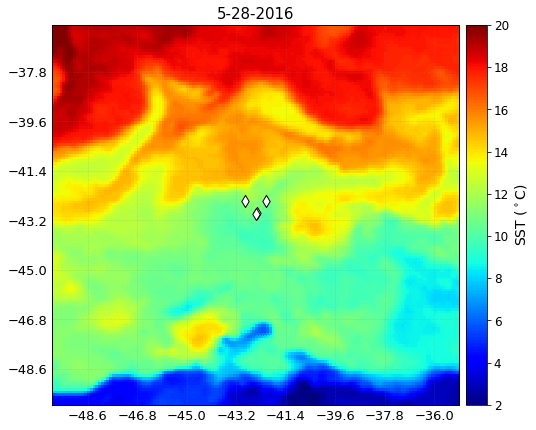

Currently plotting: 5-29-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160529.png


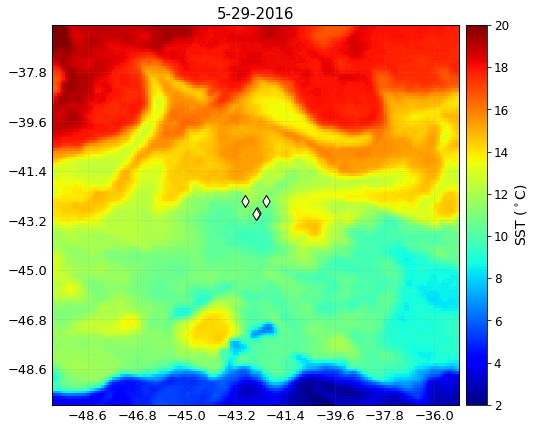

Currently plotting: 5-30-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160530.png


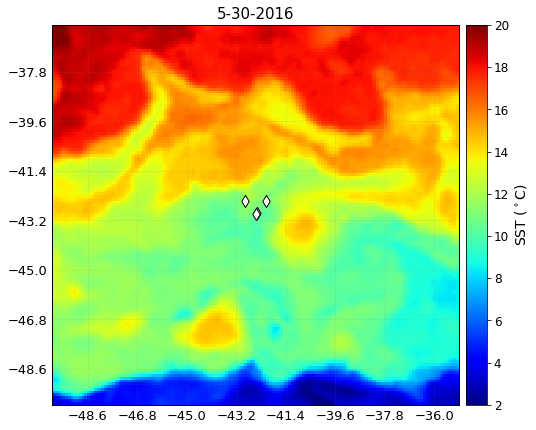

Currently plotting: 5-31-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160531.png


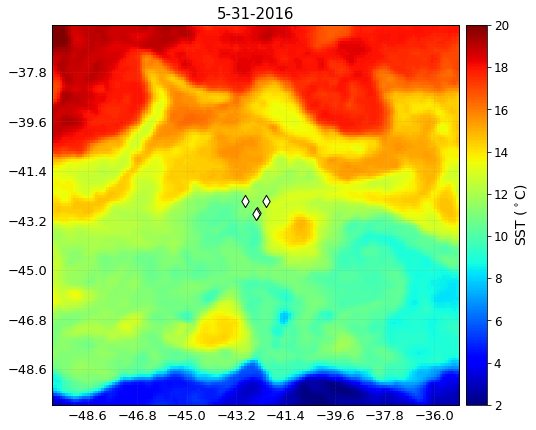

Currently plotting: 6-1-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160601.png


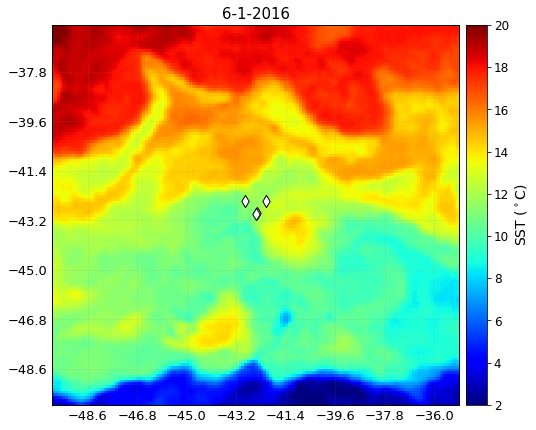

Currently plotting: 6-2-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160602.png


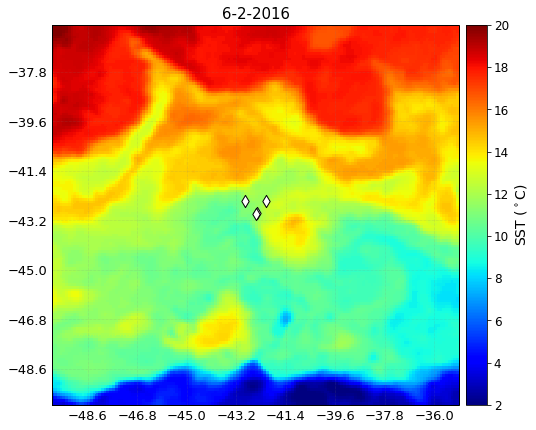

Currently plotting: 6-3-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160603.png


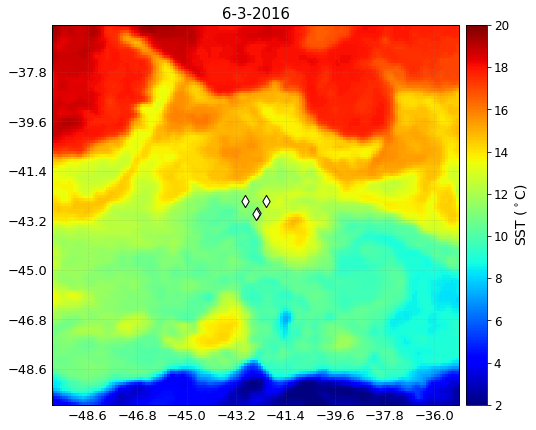

Currently plotting: 6-4-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160604.png


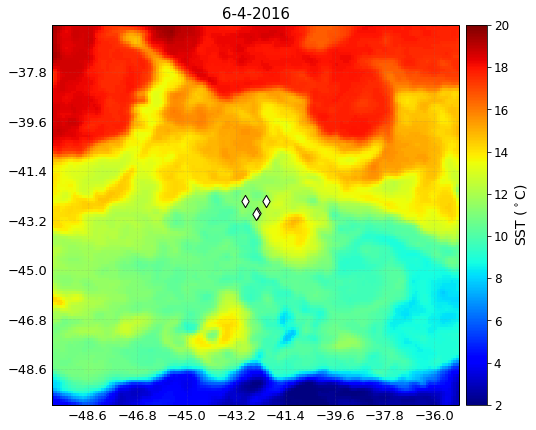

Currently plotting: 6-5-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160605.png


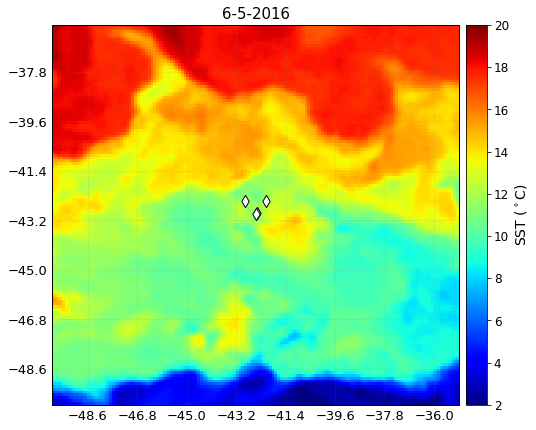

Currently plotting: 6-6-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160606.png


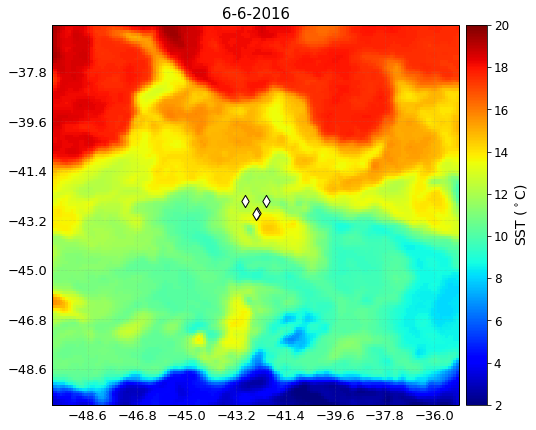

Currently plotting: 6-7-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160607.png


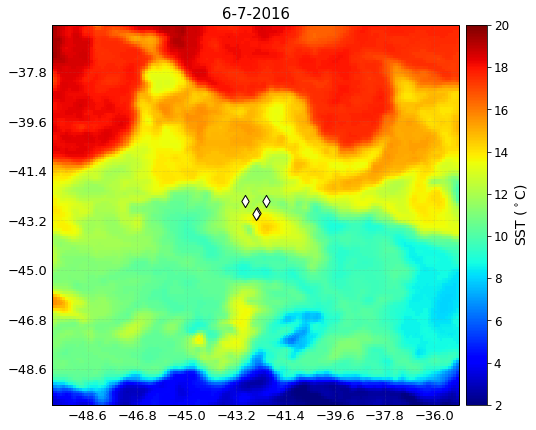

Currently plotting: 6-8-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160608.png


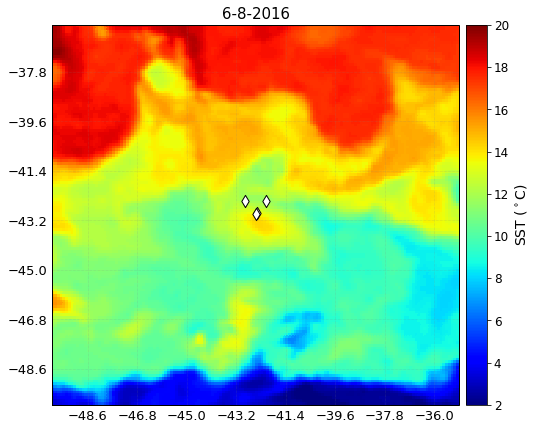

Currently plotting: 6-9-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160609.png


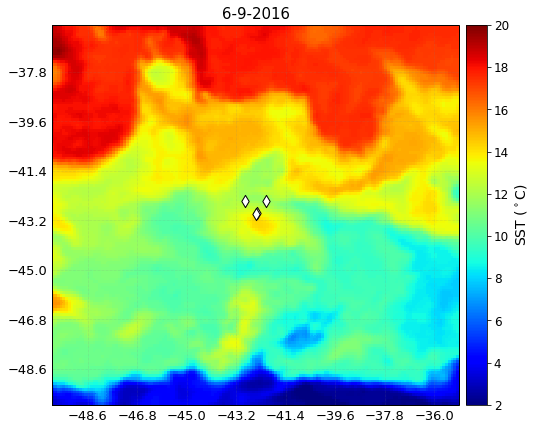

Currently plotting: 6-10-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160610.png


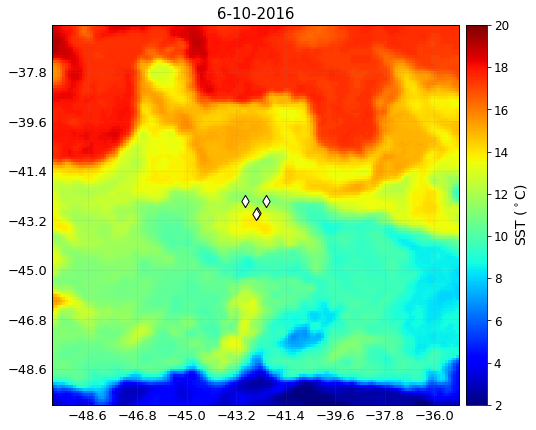

Currently plotting: 6-11-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160611.png


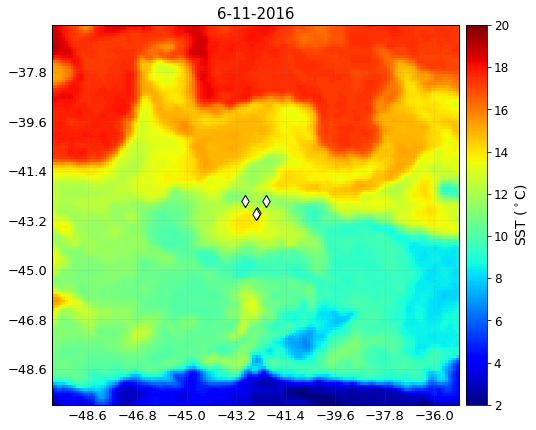

Currently plotting: 6-12-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160612.png


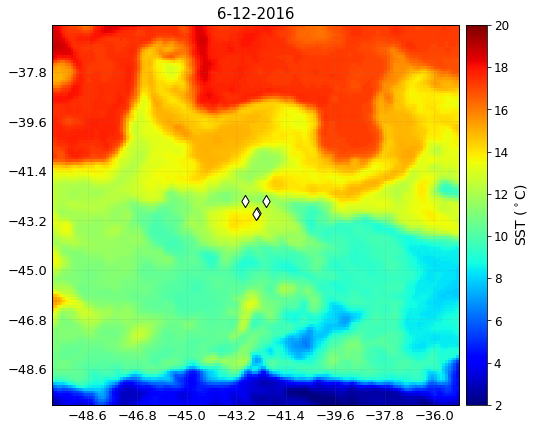

Currently plotting: 6-13-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160613.png


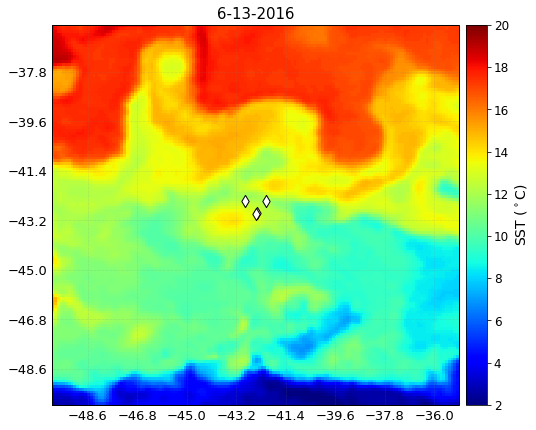

Currently plotting: 6-14-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160614.png


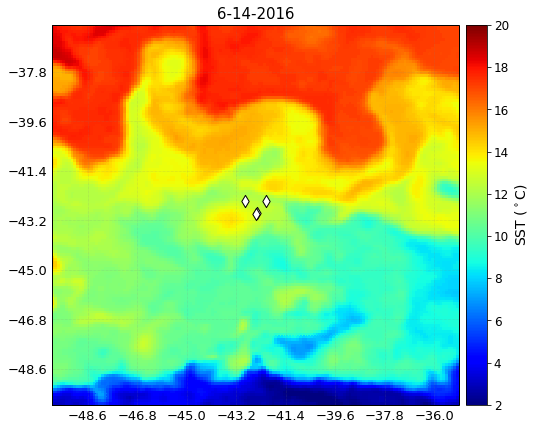

Currently plotting: 6-15-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160615.png


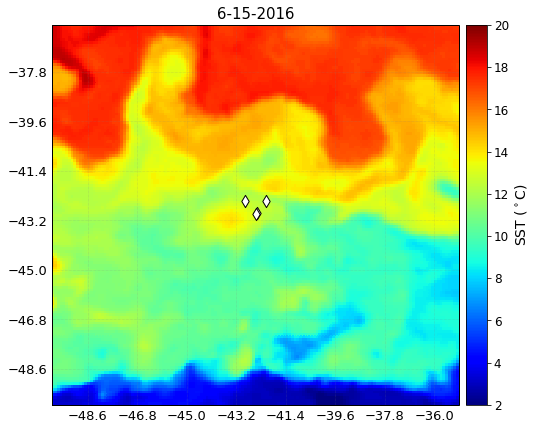

Currently plotting: 6-16-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160616.png


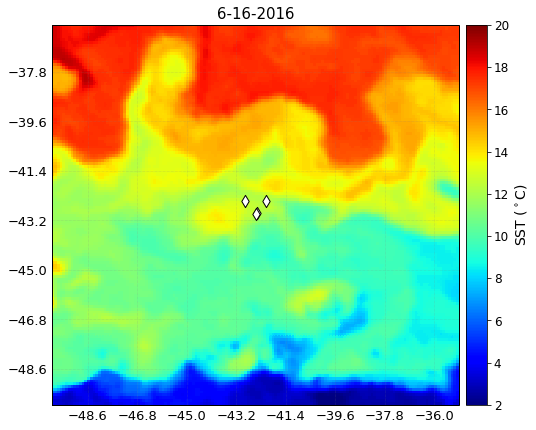

Currently plotting: 6-17-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160617.png


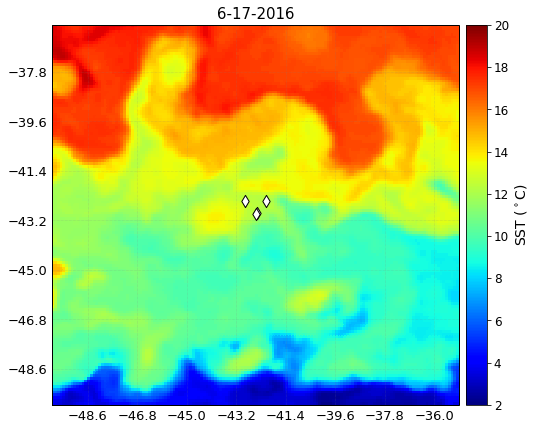

Currently plotting: 6-18-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160618.png


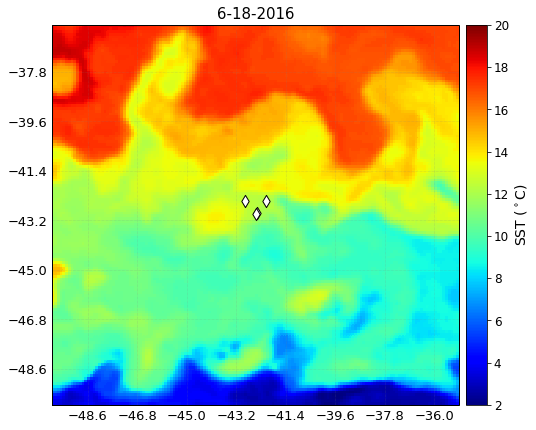

Currently plotting: 6-19-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160619.png


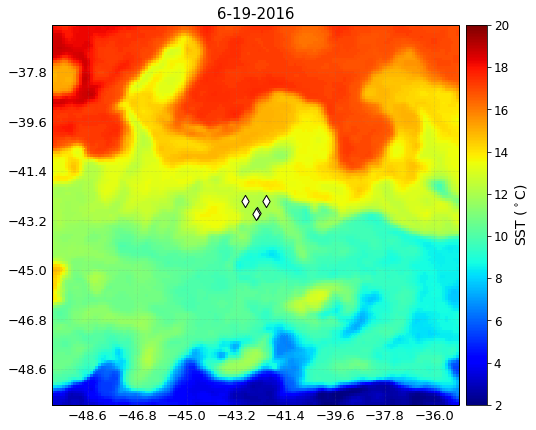

Currently plotting: 6-20-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160620.png


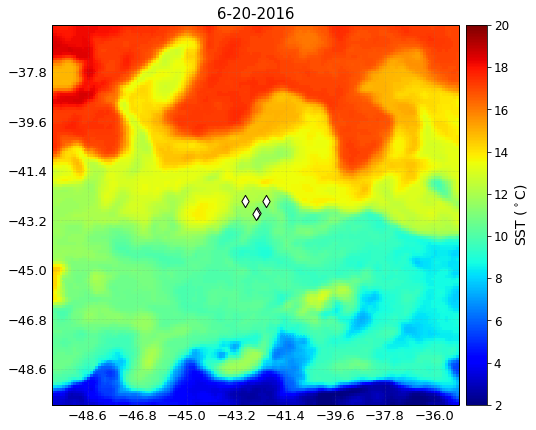

Currently plotting: 6-21-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160621.png


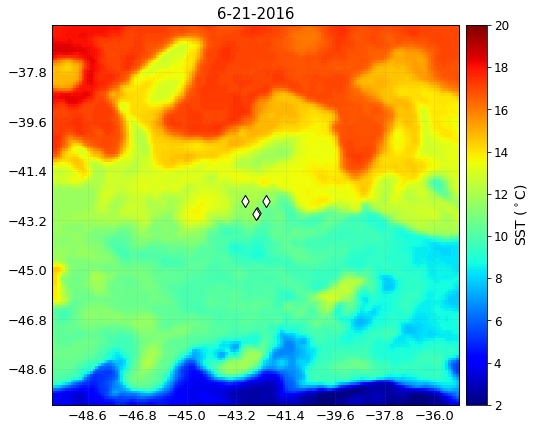

Currently plotting: 6-22-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160622.png


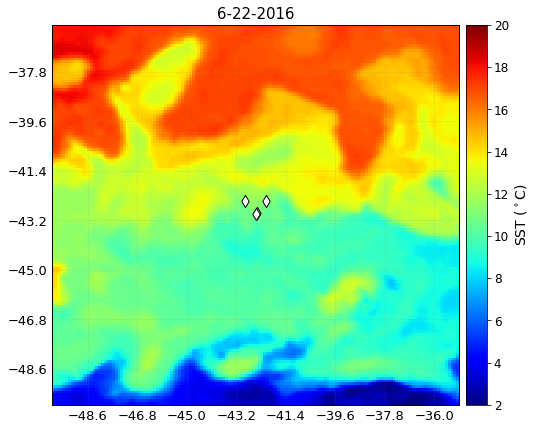

Currently plotting: 6-23-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160623.png


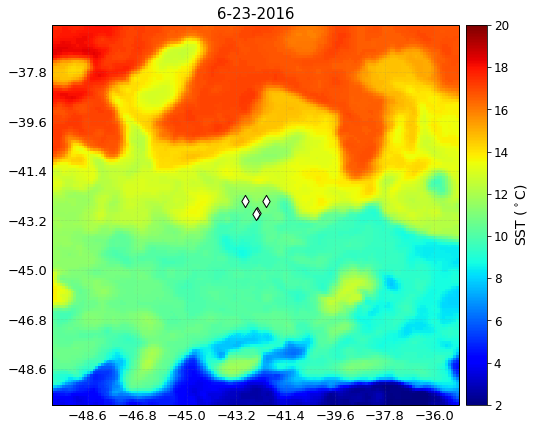

Currently plotting: 6-24-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160624.png


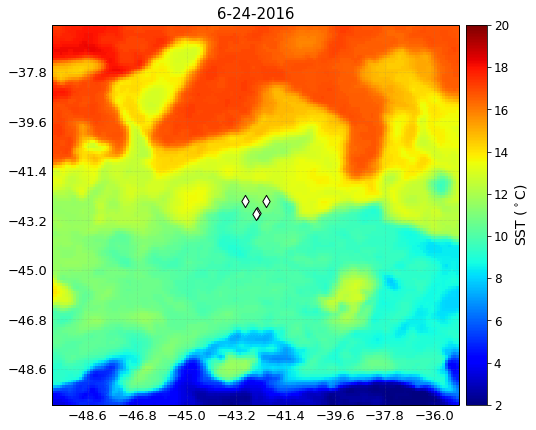

Currently plotting: 6-25-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160625.png


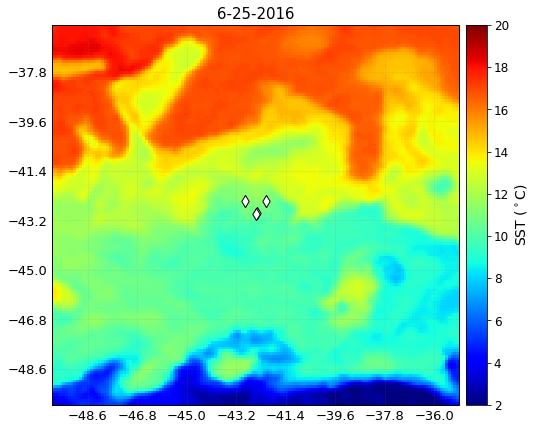

Currently plotting: 6-26-2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/extras/E02_satellite/NAVOCEANO_sst_20160626.png


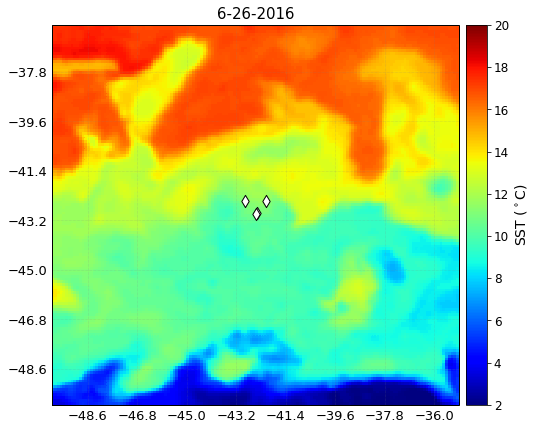

In [15]:
for t in tm:
    # get the SST data at the defined timestamp
    sst_tm = sst.sel(time=t.values)

    # convert SST to float and convert fill values to NaNs
    sst_tm = sst_tm.astype('float')
    sst_tm.values[sst_tm == -32768] = np.nan
    
    # convert using scale_factor and don't add 273.15 (keep degrees Celsius)
    sst_tm = sst_tm * sst.scale_factor
    
    lons = sst_tm.lon.values
    lats = sst_tm.lat.values
    
    # define labels for plot
    # convert timestamp to string
    timestr = '{}-{}-{}'.format(t.values.tolist().month, t.values.tolist().day, 
                                t.values.tolist().year)
    print('Currently plotting: {}'.format(timestr))

    # define plot title and color label title
    title = '{}'.format(timestr)
    color_label = 'SST ($^\circ$C)'

    # create a full save file path for the image
    stime = '{}{:02d}{:02d}'.format(t.values.tolist().year, t.values.tolist().month, t.values.tolist().day)
    #sdate = dt.datetime.strftime(pd.to_datetime(t.values), '%Y%m%dT%H%M')
    figname = 'NAVOCEANO_sst_{}.png'.format(stime)
    sfig = os.path.join(save_dir, figname)
    print('save filepath: {}'.format(sfig))
    
    # pass the necessary information to the function to create the plot, 
    # including the save file path to save plots to local machine
    plot_sst(title, color_label, lons, lats, sst_tm.values, array_location, 2, 20, sfig)

When scrolling through the images, you can see a warm core eddy ring breaking off from the Brazil current and moving west passed the array. Strong currents associated with this activity are most likely what caused the subsurface Argentine Basin moorings to be pulled down by hundreds of meters during this time frame.